In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Add, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


Load Data

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0],True)

data = []
labels = []
dataset_path = '../Vegetable'
classes = os.listdir(dataset_path)
img_rows, img_cols = 40,40


for class_id, class_name in enumerate(classes):
    folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(folder_path)
    print(class_id)
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        img = image.load_img(image_path,target_size=(img_rows, img_cols,3),color_mode='rgb')
        img_array = image.img_to_array(img)
        data.append(img_array)
        labels.append(class_id)


X = np.array(data)
Y = np.array(labels)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [4]:
x_train, x_temp, y_train, y_temp = train_test_split(X,Y, test_size=0.2, random_state=int(time.time()))
x_test,x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=int(time.time()))

Preprocessing

In [5]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3).astype('float32')/255.0
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3).astype('float32')/255.0
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 3).astype('float32')/255.0

In [6]:
#one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, len(classes))
y_test = tf.keras.utils.to_categorical(y_test, len(classes))
y_val = tf.keras.utils.to_categorical(y_val, len(classes))

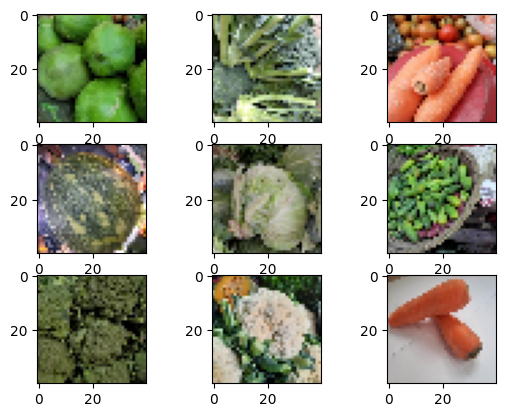

In [7]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap='gray')

plt.show()

In [9]:
def inception_module(x, filters):
    conv1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
    
    conv3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
    conv3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(conv3)

    conv5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
    conv5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(conv5)

    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(filters[3], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(pool)

    x = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return x

def create_google_net(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(32, (7, 7), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(input_layer)
    x = BatchNormalization()(x)

    x = inception_module(x, [32, 64, 64, 128, 64,32])
    x = inception_module(x, [32, 64, 64, 128, 64,32])
    x = inception_module(x, [64, 128, 128, 256, 128,64])
    
    x = inception_module(x, [64, 128, 128, 256, 128,64])
    x = Dropout(0.3)(x)

    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    
    return model



In [12]:
model = create_google_net(input_shape=(img_cols,img_rows,3), num_classes=len(classes))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 conv2d_25 (Conv2D)             (None, 40, 40, 32)   4736        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 40, 40, 32)  128         ['conv2d_25[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 conv2d_27 (Conv2D)             (None, 40, 40, 64)   2112        ['batch_normalization_1[0][

In [16]:
epochs = 20
batch_size=32

early_stop = EarlyStopping(monitor='val_loss', patience=5)

checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

history = model.fit(
    x_train,y_train,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint,early_stop]
)
score = model.evaluate(x_test,y_test)
print(f"Test score : {score[0]}")
print(f"Test accuraccy : {score[1]}")

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_9/Relu' defined at (most recent call last):
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\somet\AppData\Local\Temp\ipykernel_25572\3314564452.py", line 12, in <module>
      history = model.fit(
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\somet\anaconda3\envs\tensorflow\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d_9/Relu'
OOM when allocating tensor with shape[64,64,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_9/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3841]

In [15]:
model = tf.keras.models.load_model('./top_model.h5')

NameError: name 'history' is not defined

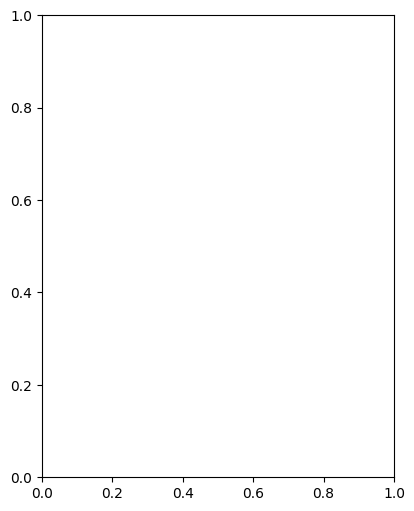

In [16]:

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('best_model.png')
plt.legend()


In [17]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

66/66 [==============================] - 13s 75ms/step


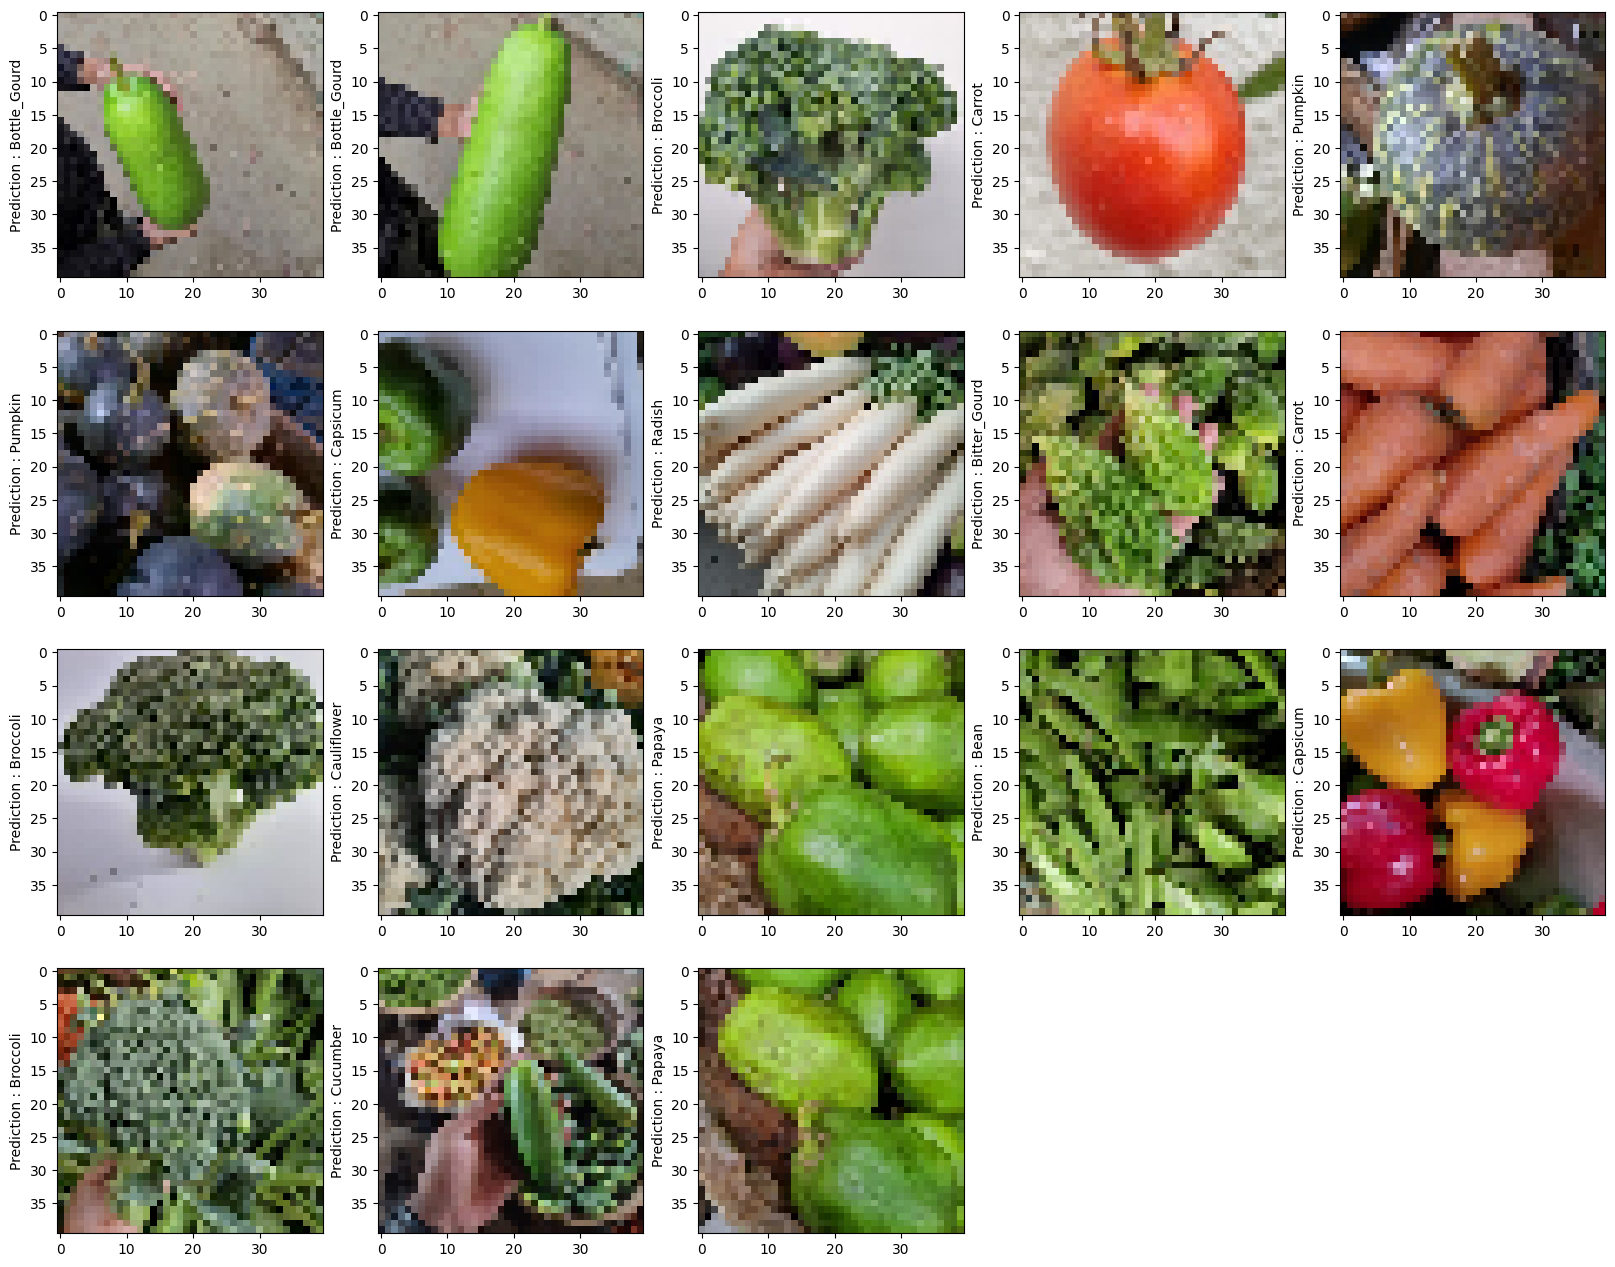

In [18]:
plt.figure(figsize=(20,20))

for i in range(18):
    plt.subplot(5,5,i+1)
    plt.imshow(x_test[i], cmap="gray")
    plt.ylabel(f"Prediction : {classes[predicted_labels[i]]}")

plt.show()